# Recurrent Neural Networks

* In this notebook, we perform (univariate) time series forcasting by applying Recurrent Neural Networks (RNN).

* There is a common data analysis task known as time-series prediction, where we have a set of data that show how something varies over time, and we want to predict how the data will vary in the future. 

* It is quite a difficult task, but a fairly important one. 

* It is useful in any field where there is data that appears over time, which is to say almost any field.

* Most notable (if often unsuccessful) uses have been in trying to predict stock markets and disease patterns. 

* The problem is that even if there is some regularity in the time-series, it can appear over many different scales. 

* For example, there is often seasonal variation—if we plotted average temperature over several years, we would notice that it got hotter in the summer and colder in the winter, but we might not notice if there was a overall upward or downward trend to the summer temperatures, because the summer peaks are spread too far apart in the data.

We will use two very distinct data sets. 

* 1. [Ozone data set](https://homepages.ecs.vuw.ac.nz/~marslast/Code/Data/PNoz.dat), i.e., daily measurement of the thickness of the ozone layer above Palmerston North in New Zealand between 1996 and 2004. 

* 2. [S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index) index set from 2001 - 2019. The S&P 500, or simply the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. The average annual total return and compound annual growth rate of the index, including dividends, since inception in 1926 has been approximately 9.8%, or 6% after inflation.

Note: more examples for RNN can be found [here](https://www.tensorflow.org/tutorials/structured_data/time_series)

## 1. 'Ozone' data set

There are 4 elements to each vector: 
- the year 
- the day of the year
- the ozone level 
- sulphur dioxide level 
- there are 2855 readings 

You can load the data using PNoz = loadtxt(’PNOz.dat’), which will load the data and stick it into an array called PNoz. To just plot the ozone data so that you can see what it looks like, use plot(arange(shape(PNoz)[0]),PNoz[:,2],’.’).

* Dataset: daily measurement of the thickness of the ozone layer above Palmerston North in New Zealand between 1996 and 2004. 

* Ozone thickness is measured in Dobson Units, which are 0.01 mm thickness at 0 degrees Celsius and 1 atmosphere of pressure. 

* Want to know how the thickness of the ozone layer varies naturally over the year. 

* This should be obvious in the plot shown in the Figure.

* A typical time-series problem is to predict the ozone levels into the future and see if you can detect an overall drop in the mean ozone level.

The following is a reminder of the steps to carry out in the analysis:

- Select inputs and outputs for your problem and consequently the input and output nodes for the network.
- Normalize the data by rescaling. 
- Identify the main parameters to configure, e.g., the network architecture and others.
- Train the network and compare for different parameters
- Assess the performance on the test data.

### Set-up of the notebook

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
import pandas as pd

Text(0,0.5,'Ozone (Dobson units)')

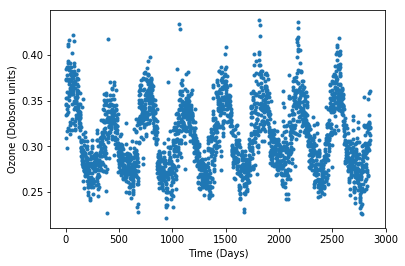

In [2]:
# loading and inspecting the data
PNoz = np.loadtxt('PNoz.dat')
tf.random.set_seed(1234)

pl.ion()
pl.plot(np.arange(np.shape(PNoz)[0]),PNoz[:,2],'.')
pl.xlabel('Time (Days)')
pl.ylabel('Ozone (Dobson units)')

# inspect the data
#!nl PNoz.dat

As you can see above, an observation is recorded every day. 

Given a specific time, let's say you want to predict the Ozone concentration 1 day in the future. In order to make this prediction, you choose to use XYZ (e.g., 360 or 720) days of observations. Thus, you would create a window containing the last 360 or 720 observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

In [3]:
# take as an input only past data
# X = PNoz[:,2:3]
# take as an input past values of all variables
X = PNoz[:,:]
y = PNoz[:,2:3]

### Pre-process the data to the LSTM shape

In [4]:
batch_size = 1
time_steps = 50
k = 0
x_final = []
y_final = []
for k in range(X.shape[0]-time_steps-1):
    x_final.append(X[k:k+time_steps,:])
    y_final.append(y[(k + time_steps + 1):(k + time_steps + 2), :])
x_final=np.stack(x_final)
y_final=np.concatenate(y_final)
# missing - one could/should in fact also normalize/standardize the data here - luckily the examples here work fine without 

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

In [5]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# A more complex network
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(64),
#    tf.keras.layers.LSTM(32, activation='relu'),       
#    tf.keras.layers.Dense(1)
#])

In [6]:
# Compile the Model

# default
#simple_lstm_model.compile(optimizer='Adam', loss='mse')

# Compile the Model with setting an exmplict learning rate
learning_rate = 0.001
simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

In [7]:
tr = int(np.ceil(x_final.shape[0]*0.9))
x_train = x_final[:tr,:,:]
x_test = x_final[tr:,:,:]
y_train = y_final[:tr,:]
y_test = y_final[tr:,:]

In [8]:
EPOCHS = 5
print('Training')
simple_lstm_model.fit(x=x_train,y=y_train, epochs=EPOCHS, validation_split=0.05)
# in sample performance
print('In sample performance')
simple_lstm_model.evaluate(x_test,y_test)
oos_pred = simple_lstm_model.predict(x_test)
is_pred = simple_lstm_model.predict(x_train)

Training
Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

75/75 [==============================] - 2s 26ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 2/5
75/75 [==============================] - 1s 18ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3/5
75/75 [==============================] - 1s 19ms/step - loss: 8.9320e-04 - val_loss: 0.0014
Epoch 4/5
75/75 [==============================] - 2s 22ms/step - loss: 7.7386e-04 - val_loss: 0.0011
Epoch 5/5
75/75 [==============================] - 1s 20ms/step - loss: 6.8390e-04 - val_loss: 0.00

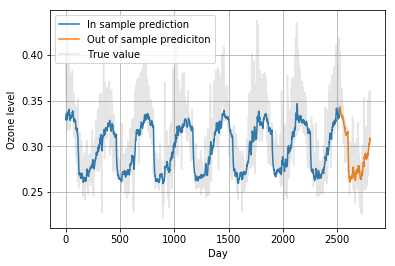

In [9]:
is_x = np.arange(0,tr)
oos_x = np.arange(tr,x_final.shape[0])
plt.plot(is_x,is_pred, label='In sample prediction')
plt.plot(oos_x, oos_pred, label ='Out of sample prediciton')
plt.plot(np.arange(0,x_final.shape[0]), y_final, label='True value', alpha=0.2, color ='grey')
plt.xlabel('Day')
plt.ylabel('Ozone level')
plt.grid(True)
plt.legend()
plt.show()

This looks pretty nice, right. Now that you have seen the basics, let's move on to part two, where you will work with a S&P500 time series.

## 2. S&P 500 data set

There are XY elements to each vector: 
- SecID
- date	
- ticker	
- low	
- high	
- open	
- close	
- volume

The file is called sp_und.csv


In [10]:
#!ls
df = pd.read_csv("sp_und.csv")

Let's look at the data

In [11]:
df.head()

,secid,date,ticker,low,high,open,close,volume
0,108105,20010102,SPX,1276.05,1320.28,1320.28,1283.27,0
1,108105,20010103,SPX,1274.62,1347.76,1283.27,1347.56,0
2,108105,20010104,SPX,1329.14,1350.24,1347.56,1333.34,0
3,108105,20010105,SPX,1294.95,1334.77,1333.34,1298.35,0
4,108105,20010108,SPX,1276.29,1298.35,1298.35,1295.86,0


In [12]:
df.size
!nl sp_und.csv

     1	secid,date,ticker,low,high,open,close,volume
     2	108105,20010102,SPX,1276.05,1320.28,1320.28,1283.27,0
     3	108105,20010103,SPX,1274.62,1347.76,1283.27,1347.56,0
     4	108105,20010104,SPX,1329.14,1350.24,1347.56,1333.34,0
     5	108105,20010105,SPX,1294.95,1334.77,1333.34,1298.35,0
     6	108105,20010108,SPX,1276.29,1298.35,1298.35,1295.86,0
     7	108105,20010109,SPX,1295.14,1311.72,1295.86,1300.8,0
     8	108105,20010110,SPX,1287.28,1313.76,1300.8,1313.27,0
     9	108105,20010111,SPX,1309.72,1332.19,1313.27,1326.82,0
    10	108105,20010112,SPX,1311.59,1333.21,1326.82,1318.32,0
    11	108105,20010116,SPX,1313.33,1327.81,1318.32,1326.65,0
    12	108105,20010117,SPX,1325.41,1346.92,1326.65,1329.47,0
    13	108105,20010118,SPX,1327.41,1352.71,1329.89,1347.97,0
    14	108105,20010119,SPX,1336.74,1354.55,1347.97,1342.54,0
    15	108105,20010122,SPX,1333.84,1353.62,1342.54,1342.9,0
    16	108105,20010123,SPX,1339.63,1362.9,1342.9,1360.4,0
    17	108105,20010124,SPX,1357.28,1369

As you can see above, an observation is recorded every day. 

Given a specific time, let's say you want to predict the return in the future. 

In [13]:
df['date']=pd.to_datetime(df['date'], format='%Y%m%d')

#### Pre-process the data to the lstm shape data

In [14]:
tf.random.set_seed(1234)
reg = 'price'
for reg in ['price','ret','abs']:
    if reg=='price':
        X = df[['close']].values
        m = np.mean(X)
        s = np.std(X)
        X=(X-np.mean(X))/np.std(X-np.mean(X))
        y = X
    if reg=='ret':
        X = df[['close']].values
        X=(X[1:,:]-X[:-1,:])/X[:-1,:]
        y = X
    if reg=='abs':
        X = df[['close']].values
        X=np.abs((X[1:,:]-X[:-1,:])/X[:-1,:])
        y = X

In [15]:
    batch_size = 1
    time_steps = 50
    k = 0
    x_final = []
    y_final = []
    date = []
    for k in range(X.shape[0]-time_steps-1):
        x_final.append(X[k:k+time_steps,:])
        y_final.append(y[(k + time_steps + 1):(k + time_steps + 2), :])
        date.append(df.loc[k+time_steps+1, 'date'])
    x_final=np.stack(x_final)
    y_final=np.concatenate(y_final)

In [16]:
    # set-up the model
    simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    
    # compile the model
    simple_lstm_model.compile(optimizer='Adam', loss='mse')

In [17]:
    tr = int(np.ceil(x_final.shape[0]*0.9))
    x_train = x_final[:tr,:,:]
    x_test = x_final[tr:,:,:]
    y_train = y_final[:tr,:]
    y_test = y_final[tr:,:]

In [18]:
    EPOCHS = 5
    print('Training')
    simple_lstm_model.fit(x=x_train,y=y_train, epochs=EPOCHS, validation_split=0.05)
    # in sample performance
    print('In sample performance')
    simple_lstm_model.evaluate(x_test,y_test)
    oos_pred = simple_lstm_model.predict(x_test)
    is_pred = simple_lstm_model.predict(x_train)
    if reg == 'price':
        is_pred=is_pred*s+m
        oos_pred=oos_pred*s+m
        y_final=y_final*s+m

Training
Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

127/127 [==============================] - 5s 39ms/step - loss: 6.9483e-05 - val_loss: 2.4758e-05
Epoch 2/5
127/127 [==============================] - 3s 25ms/step - loss: 6.4330e-05 - val_loss: 2.4315e-05
Epoch 3/5
127/127 [==============================] - 3s 20ms/step - loss: 6.4759e-05 - val_loss: 2.5011e-05
Epoch 4/5
127/127 [==============================] - 3s 26ms/step - loss: 6.4577e-05 - val_loss: 2.5836e-05
Epoch 5/5
127/127 [==============================] - 3s 26ms/step -

#### Inspect the results

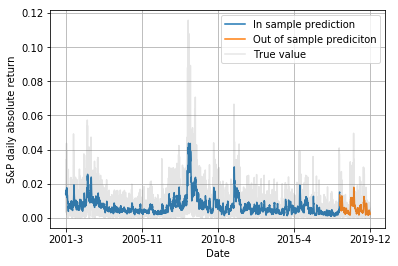

In [19]:
    is_x = np.arange(0,tr)
    oos_x = np.arange(tr,x_final.shape[0])
    plt.plot(is_x,is_pred, label='In sample prediction')
    plt.plot(oos_x, oos_pred, label ='Out of sample prediciton')
    plt.plot(np.arange(0,x_final.shape[0]), y_final, label='True value', alpha=0.2, color ='grey')
    if reg == 'price':
        plt.ylabel('S&P $ values')
    if reg == 'ret':
        plt.ylabel('S&P daily return')
    if reg == 'abs':
        plt.ylabel('S&P daily absolute return')

    a = np.ceil(np.linspace(0, len(date)-1,5)).astype(int)
    b = [str(date[x].year)+'-'+str(date[x].month) for x in a]
    plt.xticks(a, b)
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()

    plt.show()